# FIT5196 Assessment 2
#### Student Name: Hazel Titley
#### Student Number: 32565895

Date: 17/09/2021

Environment: Python 3.7.9 and Anaconda 2020.11

Libraries used:
* pandas
* numpy
* matplotlib
* re
* datetime
* ast
* networkx
* sklearn
* nltk
* sympy
* collections

This code aims to clean dirty data, missing data, and outlier data from 3 separate files. It is split into 5 main sections:

* Part 0 - importing data and libraries
* Part 1 - imputing missing data 
* Part 2 - filtering outlier data
* Part 3 - cleaning dirty data
* Part 4 - exporting data

Parts 1 to 3 deal with the processing of the data. The processes are outlined in more detail within each section. <br>
<br>
Note: Please ensure that the data is stored in the same directory as this jupyter file, otherwise the code will not run.

## Part 0 - Importing libraries and data
before any data can be processed, it needs to read in to the working memory, and the relevant libraries imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import ast
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sympy
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hazeltitley/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#reading in files
outlier_data = pd.read_csv("32565895_outlier.csv")
missing_data = pd.read_csv("32565895_missing.csv")
dirty_data = pd.read_csv("32565895_dirty.csv")
rest_data = pd.read_csv("restaurant_data_student.csv")
nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")
#inspecting one of the dataframes to ensure reading has been successful
missing_data.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD221584,REST1137,CUST06498,COUR4108,-37.825367,144.982814,2020-11-26,06:31:38,0,0,Motorbike,"[('crispy corn', 1), ('momos', 1), ('mocktails...",20,88.784,2742.0,5,NaN,3.4576
1,ORD185757,REST1572,CUST08996,COUR2623,-37.812679,144.959576,2020-09-27,15:53:24,0,1,Car,"[('pizza', 1), ('veg starter', 2)]",45,33.121,1045.0,3,NaN,3.6992
2,ORD058245,REST1946,CUST09230,COUR2476,-37.799510,144.935378,2020-11-24,22:48:47,0,0,Bike,"[('chicken tenders', 3), ('yakhni pulao', 3), ...",0,146.830,3312.0,17,NaN,4.6442
3,ORD182651,REST1572,CUST03209,COUR0581,-37.811442,144.927331,2020-05-29,08:06:35,0,0,Bike,"[('cocktails', 1), ('sea food', 3)]",0,37.940,4292.0,21,NaN,4.1049
4,ORD189538,REST1137,CUST08767,COUR3877,-37.815733,144.982268,2020-12-28,11:40:13,0,0,Car,"[('gulab jamun', 2), ('pizza', 2), ('chicken b...",20,71.712,1576.0,4,NaN,2.7549


as can be seen the dataframes have been read in successfully.

## Part 1 - Imputing missing data
In this section the missing data imputed. That is, the restaurant ratings and shortest distance values are filled in. This is done using Djikstras algorithm and Sentiment Analysis. The sentiment analysis requires analysis of the given restaurant reviews, and Djikstras requires the creation of a graph using the edges and nodes provided in the edges.csv and nodes.csv respectively. More detail is provided in the relevant sub headings.

### 1.1 - calculating the rating
the restaurant ratings are calculated using sentiment analysis. to calculate each rating, the reviews first need to be read in from the the restaurant_data_student.csv and evaluated as a list. for each review in the list, sentiment analysis is performed. This works by associating each word in the review with a polarity score which represents the underlying sentiment (high scores mean the word is positive in meaning, low means negative) (Bird et al., 2009). a normalised, aggregated score (compound score) can then be determined for each review. this is done using the nltk SentimentIntensityAnalyzer and associated polarity_scores. this is caluclated for every review, so an average compound review score can be caluclated. this is converted to a rating using the equation given in the assessment outline, and the scores saved to a dictionary. this dictionary can then be used to fill in the missing restaurant ratings in the data set. <br?
N.B: these rating are used later to clean the dirty data.

In [3]:
#only calculating the rating for restaurants in my data set
rests = missing_data["restaurant_id"].unique()
#creating a dictionary which will contain the determined ratings
rest_rating = {}
#calculating the ratings for each restaurant
for rest in rests:
    review_scores = []
    for i in range(len(rest_data)):
        #retrieving restaurant reviews from the csv
        if rest == rest_data.loc[i, "restaurant_id"]:
            #breaking reviews into list by regexing
            reviews = ast.literal_eval(rest_data.loc[i, "reviews_list"])
            break  
    #calculating the compound score for each review
    for review in reviews:
        score = SentimentIntensityAnalyzer().polarity_scores(review)['compound'] # (Bird et al., 2009)
        review_scores.append(score)
    #averaging the compound score
    rs = sum(review_scores)/len(review_scores)
    #calculating rating using the given formula
    rating = 10*(rs + 0.9623)/(1.9533)
    #saving rating and corresponding restaurant id to dictionary
    rest_rating[rest]= round(rating, 2)

In [4]:
#printing the rating to inspect
print(rest_rating)

{'REST1137': 9.6, 'REST1572': 9.28, 'REST1946': 4.96, 'REST2155': 9.54, 'REST2185': 8.18}


now the ratings have been calculated, the missing values can be imputed.

In [5]:
#filling in the missing ratings
for i in range(len(missing_data)):
    rest_id = missing_data.loc[i, "restaurant_id"]
    missing_data.loc[i, "restaurant_rating"] = rest_rating[rest_id]

In [6]:
missing_data["restaurant_rating"].isnull().values.any()

False

this output indicates there are no null values left in this column so the imputation has been successful!

### 1.2 - calculating the shortest distance
The shortest distance between customer and restaurant is caluclated using Djikstras algorithm (Wikipedia 2021). to do this a graph first needs to be created using the edges supplied in edges.csv. each edge is given a weight corresponding to distance. the shortest distance is then found by retrieving the target and source node, and using nx.single_source_dijkstra (Hagberg et al., 2008) to calculate the path distance. the missing values can then be filled in.

In [7]:
#creating graph
G = nx.Graph()
#adding edges to graph with distance as attribute
for i in range(len(edges)):
    n1 = round(edges.loc[i, "u"])
    n2 = round(edges.loc[i, "v"])
    d = round(edges.loc[i, "distance(m)"])
    G.add_edge(n1, n2, dist=d) #https://networkx.org/documentation/stable/tutorial.html

now the graph has been successfully made, the shortest distance can be calculated for each entry in the dataframe.

In [8]:
#isolating the missing data
m_dist_rows = missing_data[missing_data["shortest_distance_to_customer"].isnull()].index.tolist()

for i in m_dist_rows:
    c_lat = missing_data.loc[i, "customer_lat"]
    c_lon = missing_data.loc[i, "customer_lon"]
    r_id = missing_data.loc[i, "restaurant_id"]
    #finding restaurant node
    for j in range(len(rest_data)):
        if r_id == rest_data.loc[j, "restaurant_id"]:
            r_node = rest_data.loc[j, "rest_nodes"]
            break
    #finding customer node
    for k in range(len(nodes)):
        if round(c_lat, 7) == round(nodes.loc[k, "lat"], 7) and round(c_lon, 7) == round(nodes.loc[k, "lon"], 7):
            c_node = nodes.loc[k, "node"]
            break
    #calculating shortest path length (by distance)
    distance,path=nx.single_source_dijkstra(G, source=r_node, target=c_node, weight='dist') 
    missing_data.loc[i, "shortest_distance_to_customer"] = int(distance)

missing_data.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD221584,REST1137,CUST06498,COUR4108,-37.825367,144.982814,2020-11-26,06:31:38,0,0,Motorbike,"[('crispy corn', 1), ('momos', 1), ('mocktails...",20,88.784,2742.0,5,9.60,3.4576
1,ORD185757,REST1572,CUST08996,COUR2623,-37.812679,144.959576,2020-09-27,15:53:24,0,1,Car,"[('pizza', 1), ('veg starter', 2)]",45,33.121,1045.0,3,9.28,3.6992
2,ORD058245,REST1946,CUST09230,COUR2476,-37.799510,144.935378,2020-11-24,22:48:47,0,0,Bike,"[('chicken tenders', 3), ('yakhni pulao', 3), ...",0,146.830,3312.0,17,4.96,4.6442
3,ORD182651,REST1572,CUST03209,COUR0581,-37.811442,144.927331,2020-05-29,08:06:35,0,0,Bike,"[('cocktails', 1), ('sea food', 3)]",0,37.940,4292.0,21,9.28,4.1049
4,ORD189538,REST1137,CUST08767,COUR3877,-37.815733,144.982268,2020-12-28,11:40:13,0,0,Car,"[('gulab jamun', 2), ('pizza', 2), ('chicken b...",20,71.712,1576.0,4,9.60,2.7549


In [9]:
missing_data["shortest_distance_to_customer"].isnull().values.any()

False

this output indicates there are no null values left in this column so the imputation has been successful! However due to a bug converting numpy 64 values to integers, all data entries are followed by a ".0". this is impossible to get rid of whilst keeping the data numeric, so for now it is ignored. Later on this can be removed by converting the values to strings and using regex to remove the ".0" where it appears.

### 1.3 - training regression model
to impute the missing delivery charges, a regression model needs to be created (Pedregosa et al., 2011). to evaluate the how well the model works it needs to be tested on unseen data. By comparing the predicted values to the listed, the goodness of fit can be evaluated (using RMSE and R^2). R^2 provides an indicator of how well the model explains variation in the data. Ideally it should be 1, however this data is expected to contain some noise, so this will not be possible. RMSE provides an indicator of error and hence should be minimised for a good fit. So the model can be effectively evaluated, the data needs to be split into training and testing sets (with neither containing nulls). The model can be trained on the training data, and validated on the test. Once validated, a new model can then be trained on the whole dataset (in order to capture the most variation), and used to impute missing values.

In [10]:
#isolating relevant columns
md = pd.DataFrame(missing_data,columns=["restaurant_rating", "is_peak_time", "is_weekend", "travel_time_minutes", 'delivery_charges'])
#removing nulls
md = md.dropna(how='any',axis=0)
#splitting data into independent and dependent variables
x = pd.DataFrame(md,columns=["restaurant_rating", "is_peak_time", "is_weekend", "travel_time_minutes"]) 
y = pd.DataFrame(md,columns=['delivery_charges'])
#splitting into test and training sets:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)
# creating a Linear regression object and training it on the data
intial_model = LinearRegression().fit(x_train,y_train) # (Pedregosa et al., 2011)

the model has now been trained and can be tested on the unseen data to determine whether it is a good fit for the data.

In [11]:
#predicting outcomes on the test set and using them to evaluate the model
y_prediction =  intial_model.predict(x_test)
predictions = y_test.copy()
predictions['prediction'] = y_prediction
predictions.head()
#printing accuracy metrics
print("r2 score is: ", r2_score(y_test,y_prediction))
print("root_mean_squared error is: ",np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 score is:  0.9568494652052737
root_mean_squared error is:  0.20917087803626155


as can be seen, the RMSE is low and the r squared is high. This indicates this model is a good fit. This is expected (given the charges dependence on the values), but nice to be confirmed. To capture as much variation as possible in the data, its important to use a large training set. for this reason, a new model should be trained on the full data set for increased accuracy. This will make it better for filling in the missing values and identifying outliers.

#### 1.3.1 - retraining model

In [12]:
#creating a model
final_model = LinearRegression()
#training it on the data
final_model.fit(x,y) # (Pedregosa et al., 2011)

LinearRegression()

the model has now been retrained on the full dataset, and can be used to impute the missing values.

In [13]:
#isolating rows with missing data
missing_rows = missing_data[missing_data["delivery_charges"].isnull()].index.tolist()
missing_vals = missing_data.iloc[missing_rows,:]
missing_vals_x = pd.DataFrame(missing_vals,columns=["restaurant_rating", "is_peak_time", "is_weekend", "travel_time_minutes"])
missing_vals_x = missing_vals_x.apply(pd.to_numeric)
#predicting values
y_pred =  final_model.predict(missing_vals_x)
#filling in dataframe
missing_data.loc[missing_rows,"delivery_charges"] = y_pred
missing_data["delivery_charges"] = missing_data["delivery_charges"].round(4)
missing_data.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD221584,REST1137,CUST06498,COUR4108,-37.825367,144.982814,2020-11-26,06:31:38,0,0,Motorbike,"[('crispy corn', 1), ('momos', 1), ('mocktails...",20,88.784,2742.0,5,9.60,3.4576
1,ORD185757,REST1572,CUST08996,COUR2623,-37.812679,144.959576,2020-09-27,15:53:24,0,1,Car,"[('pizza', 1), ('veg starter', 2)]",45,33.121,1045.0,3,9.28,3.6992
2,ORD058245,REST1946,CUST09230,COUR2476,-37.799510,144.935378,2020-11-24,22:48:47,0,0,Bike,"[('chicken tenders', 3), ('yakhni pulao', 3), ...",0,146.830,3312.0,17,4.96,4.6442
3,ORD182651,REST1572,CUST03209,COUR0581,-37.811442,144.927331,2020-05-29,08:06:35,0,0,Bike,"[('cocktails', 1), ('sea food', 3)]",0,37.940,4292.0,21,9.28,4.1049
4,ORD189538,REST1137,CUST08767,COUR3877,-37.815733,144.982268,2020-12-28,11:40:13,0,0,Car,"[('gulab jamun', 2), ('pizza', 2), ('chicken b...",20,71.712,1576.0,4,9.60,2.7549


In [14]:
#checking if the dataframe has any missing data left
missing_data.isnull().values.any()

False

No missing data remains, so all the missing values have been successfully imputed and Part 1 is complete.

## Part 2 - filtering outlier data
Outlier filtering is performed on the delivery_charges column in the outlier_data.csv file. This data is multivariate and depends on:
* Travel time between restaurant and customer.
* Whether the delivery occurred during a peak period.
* Whether the delivery occurred during a weekend.
* The restaurant rating <br>

As the data is multivariate, it would be bad practise to remove outliers based off the delivery_charges value alone.
as filtering on delivery charges alone could bias the data. for example, orders made during peak times on a weekend are likely to incur larger delivery fees, and are hence more likely to be removed during outlier filtering. To minimise bias and identify outliers, it is better practise to fit a multiple linear regression model based on the influencing factors (NIST 2013). the residuals can then be used to indentiy outliers. this makes the data univariate, so points can be removed via the boxplot method. As the outlier data contains outliers, these could impact the training of the model. Hence, the model should be trained on an alternative dataset. as the missing data is MCAR, it provides a suitable training dataset. Note: this regression model (final_model) has already been created in Part 1 in order to fill in the missing values, so this is just used again for outlier identification.

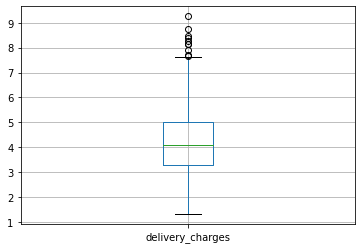

In [15]:
#plotting data for inspection
%matplotlib inline
bp = outlier_data.boxplot(column="delivery_charges")

as can be seen from the boxplot, the outliers are dense and grouped, this suggests the data is multivariate and that using this boxplot alone to identify outliers is a bad idea. this confirms the information given in the assessment outline. that is, an alternative method should be used to identify outliers (like residuals).

### 2.1 calculating residuals
the delivery charges are rpedicted using the final model from part 1. the residuals are just the difference between these values and the listed charges. the processing is done on a copy of the original dataframe, to avoid altering the data. identified outliers can then be removed from the original via indexing. 

In [16]:
#resdiuals are calculated on a copy of the outlier_data (so as to not uneccessarily alter it)
od = outlier_data.copy()
#creating restaurant rating column
od.loc[i, "restaurant_rating"] = 0
#setting rating values
for i in range(len(od)):
    rest_id = od.loc[i, "restaurant_id"]
    od.loc[i, "restaurant_rating"] = rest_rating[rest_id]
#isolating x variables
od_x = pd.DataFrame(od,columns=["restaurant_rating", "is_peak_time", "is_weekend", "travel_time_minutes"])
od_x = od_x.apply(pd.to_numeric)
#predicting delivery_charge values
y_pred =  final_model.predict(od_x)
#saving predictions to dataframe
od['predicted_delivery_charges'] = y_pred
#saving residuals
od['residual_value'] = od['predicted_delivery_charges'] - od['delivery_charges']
od.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges,restaurant_rating,predicted_delivery_charges,residual_value
0,ORD080681,REST1946,CUST13978,COUR2927,-37.813016,144.951538,2020-08-04,08:38:14,0,0,Car,"[('roti', 3), ('paneer malai tikka', 1), ('but...",10,120.744,1792,4,3.8732,4.96,3.661440,-0.211760
1,ORD046142,REST2185,CUST11790,COUR4300,-37.804585,144.967553,2020-02-16,12:11:52,1,1,Motorbike,"[('shahi paneer', 3), ('rajma', 2), ('biryani'...",45,74.640,3019,6,5.8251,8.18,5.879397,0.054297
2,ORD005100,REST2155,CUST06044,COUR1049,-37.806317,144.941575,2020-07-16,17:16:29,0,0,Motorbike,"[('butter kulcha', 1), ('thali', 3)]",20,37.680,5828,12,3.9266,9.54,3.762545,-0.164055
3,ORD030320,REST1137,CUST07409,COUR1647,-37.823595,144.967131,2020-11-28,01:50:46,0,1,Bike,"[('momos', 3), ('chicken kebab', 2), ('crispy ...",0,92.700,2344,12,4.7621,9.60,4.773202,0.011102
4,ORD312831,REST2185,CUST00686,COUR1688,-37.817256,144.962170,2020-06-08,04:17:08,0,0,Bike,"[('custard', 1), ('jeera rice', 3), ('protein ...",0,62.260,1085,5,3.4256,8.18,3.279025,-0.146575


as can be seen, predicted an residual values have been added to this copy of the dataframe, indicating the calculations have been successful. now the outliers can be identified from their residual values.

### 2.2 identifying outliers by the boxplot method
A boxplot provides a low dimensional subspace for outlier detection. using this method, an outlier is defined as any point that lies outside the whiskers of the box plot (NIST 2013). That is, 1.5 times the interquartile range above the upper quartile or 1.5 times the interquartile range below the lower quartile. these values are calculated and used to flag outlier data. the indexes of these values are then identified and used to remove data from the original dataframe. The boxplots can then be plotted again, to confirm filtering success.

In [17]:
#calculating quartiles and IQR
third_q = od.quantile(0.75, axis=0)["residual_value"]
first_q = od.quantile(0.25, axis=0)["residual_value"]
iqr = third_q-first_q

#creating flag column
od["flag"] = 0
#falgging data if it lies outside of whisker values
for i in range(len(od)):
    upper_lim = third_q + 1.5*iqr
    lower_lim = first_q - 1.5*iqr
    if od.loc[i, "residual_value"] > upper_lim or od.loc[i, "residual_value"] < lower_lim:
        od.loc[i, "flag"] = 1

od.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,...,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges,restaurant_rating,predicted_delivery_charges,residual_value,flag
0,ORD080681,REST1946,CUST13978,COUR2927,-37.813016,144.951538,2020-08-04,08:38:14,0,0,...,"[('roti', 3), ('paneer malai tikka', 1), ('but...",10,120.744,1792,4,3.8732,4.96,3.661440,-0.211760,0
1,ORD046142,REST2185,CUST11790,COUR4300,-37.804585,144.967553,2020-02-16,12:11:52,1,1,...,"[('shahi paneer', 3), ('rajma', 2), ('biryani'...",45,74.640,3019,6,5.8251,8.18,5.879397,0.054297,0
2,ORD005100,REST2155,CUST06044,COUR1049,-37.806317,144.941575,2020-07-16,17:16:29,0,0,...,"[('butter kulcha', 1), ('thali', 3)]",20,37.680,5828,12,3.9266,9.54,3.762545,-0.164055,0
3,ORD030320,REST1137,CUST07409,COUR1647,-37.823595,144.967131,2020-11-28,01:50:46,0,1,...,"[('momos', 3), ('chicken kebab', 2), ('crispy ...",0,92.700,2344,12,4.7621,9.60,4.773202,0.011102,0
4,ORD312831,REST2185,CUST00686,COUR1688,-37.817256,144.962170,2020-06-08,04:17:08,0,0,...,"[('custard', 1), ('jeera rice', 3), ('protein ...",0,62.260,1085,5,3.4256,8.18,3.279025,-0.146575,0


In [18]:
#finding indexes with flagged data
indexes = od.index[od["flag"]==1].tolist()
#removing outliers from dataset according to index value
outlier_data = outlier_data.drop(indexes)
outlier_data.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges
0,ORD080681,REST1946,CUST13978,COUR2927,-37.813016,144.951538,2020-08-04,08:38:14,0,0,Car,"[('roti', 3), ('paneer malai tikka', 1), ('but...",10,120.744,1792,4,3.8732
1,ORD046142,REST2185,CUST11790,COUR4300,-37.804585,144.967553,2020-02-16,12:11:52,1,1,Motorbike,"[('shahi paneer', 3), ('rajma', 2), ('biryani'...",45,74.640,3019,6,5.8251
2,ORD005100,REST2155,CUST06044,COUR1049,-37.806317,144.941575,2020-07-16,17:16:29,0,0,Motorbike,"[('butter kulcha', 1), ('thali', 3)]",20,37.680,5828,12,3.9266
3,ORD030320,REST1137,CUST07409,COUR1647,-37.823595,144.967131,2020-11-28,01:50:46,0,1,Bike,"[('momos', 3), ('chicken kebab', 2), ('crispy ...",0,92.700,2344,12,4.7621
4,ORD312831,REST2185,CUST00686,COUR1688,-37.817256,144.962170,2020-06-08,04:17:08,0,0,Bike,"[('custard', 1), ('jeera rice', 3), ('protein ...",0,62.260,1085,5,3.4256


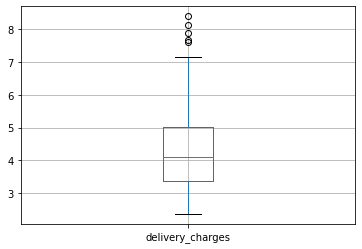

In [19]:
#plotting data
%matplotlib inline
bp = outlier_data.boxplot(column="delivery_charges")

As can be seen, a significant portion of the outliers have been removed, indicating the filtering was successful adn part 2 is complete.

## Part 3 -  cleaning the dirty data
as each line of code only contains one error, an index of changes made is kept to ensure each line is only fixed once. I begin by fixing easy errors. By this I mean i check for syntactic errors (like incorrectly saved dates), or errors which only affect a single column. After that, more complex issues are fixed. This is done by looking for contradictions within the data (like ensuring is_weekend is correct for the given date). Fixing the order price and delivery time are the most complex process for this data processing, and these are done last. The order price issue is complex as it requires the use of linear algebra to determine the price of the menu items, and is impacted by the discount given. where the dicount coupon can be changed to produce the given order price, this is done, otherwise the order price is changed. delivery_time is also complicated as it depends on the vehicle and the shortest path calculated. Djikstras is used to validate the shortest path. Where the carrier vehicle can be altered to produce the given time, this is done, otherwise the time is altered. The steps are explained in further detail below, as they are executed. The steps are outlined in more detail at each subheading.

In [20]:
#initialising index
changed_i = list()

### 3.1 - fixing latitude and longitude
as latitude values are only valid where they are between -90 and 90, errors are easy to identify. the same goes for longitude (except the range is 80 to 180). errors are likely to be due to misplacement of the values. that is, accidentally saving the latitude under the longitude column, and longitude under latitude. Hence, these errors can be fixed by swapping the values into their correct columns.

In [21]:
#converting data to numeric
dirty_data["customer_lat"] = pd.to_numeric(dirty_data["customer_lat"])
dirty_data["customer_lon"] = pd.to_numeric(dirty_data["customer_lon"])

In [22]:
#checking if their is invalid data
for i in range(len(dirty_data)):
    if float(dirty_data.loc[i, "customer_lon"])<80 or float(dirty_data.loc[i, "customer_lon"])>180 or abs(float(dirty_data.loc[i, "customer_lat"]))>90:
        print("DATA CONTAINS ERROR")
        break

DATA CONTAINS ERROR


as per the output, the dataset contains at least one invalid longitude

In [23]:
#looping through the data
for i in range(len(dirty_data)):
    # if the latitude is wrong, ans so is the longitude, the values are swapped
    if abs(float(dirty_data.loc[i, "customer_lat"]))>90:
        if float(dirty_data.loc[i, "customer_lon"])<80 or float(dirty_data.loc[i, "customer_lon"])>180:
            #swapping values around
            print("LAT AND LON SWAPPED AT INDEX: {}".format(i))
            changed_i.append(i)
            lat = float(dirty_data.loc[i, "customer_lat"])
            lon = float(dirty_data.loc[i, "customer_lon"])
            dirty_data.loc[i, "customer_lat"] = lon
            dirty_data.loc[i, "customer_lon"] = lat
        else:
            print("WEIRD DATA - latitude is incorrect but longitude appears correct")

LAT AND LON SWAPPED AT INDEX: 6
LAT AND LON SWAPPED AT INDEX: 197
LAT AND LON SWAPPED AT INDEX: 274
LAT AND LON SWAPPED AT INDEX: 426
LAT AND LON SWAPPED AT INDEX: 490
LAT AND LON SWAPPED AT INDEX: 492


checking the data no longer contains any issues

In [24]:
#looping through data
for i in range(len(dirty_data)):
    error = False
    #printing error if invalid longitude or latitude found
    if float(dirty_data.loc[i, "customer_lon"])<80 or float(dirty_data.loc[i, "customer_lon"])>180:
        print("DATA STILL CONTAINS ERROR")
        error = True
        break
if not error:
    print("DATA SUCCESSFULLY FIXED")

DATA SUCCESSFULLY FIXED


this confirms that the columns have been successfully cleaned.

### 3.2 - fixing dates and checking time
the date and time formats are checked to ensure they are valid
#### 3.2.1 - fixing dates
the date column is likely to contain some syntactical errors, so needs to be checked. incorrectly formated dates are saved with the index as tuples to a list. Regexing is then used to process the dates and automatically convert them to a valid format.

In [25]:
#isolating incorrectly formatted dates
date_errors = []
for i, item in enumerate(dirty_data['date']):
    try:
        fixed_data = datetime.strptime(item, '%Y-%m-%d')
    except ValueError:
        date_errors.append(tuple((i, item)))
        print('ERROR - unable to convert data to date at index: {}, FORMAT: {}'.format(i, item))
        changed_i.append(i)

ERROR - unable to convert data to date at index: 60, FORMAT: 2020-20-11
ERROR - unable to convert data to date at index: 98, FORMAT: 2020-27-09
ERROR - unable to convert data to date at index: 153, FORMAT: 2020-Oct-07
ERROR - unable to convert data to date at index: 155, FORMAT: Fri Apr 10 00:00:00 2020
ERROR - unable to convert data to date at index: 166, FORMAT: 2020-24-01
ERROR - unable to convert data to date at index: 205, FORMAT: 2020-26-12
ERROR - unable to convert data to date at index: 236, FORMAT: 2020-26-02
ERROR - unable to convert data to date at index: 265, FORMAT: Fri Dec  4 00:00:00 2020
ERROR - unable to convert data to date at index: 381, FORMAT: 2020-16-12
ERROR - unable to convert data to date at index: 442, FORMAT: 2020-24-10


As can be seen, some of the date values are invalid or in the incorrect format. There arent many errors, so these could be fixed manually. However automating the process allows the process to be implemented on larger datasets (so this is what is done). where the months are too large, but the date (day) could be considered months, these are assumed to be in the wrong order and swapped. where the month is listed by its name, it is just converted to numeric. time stamps and day names are removed.

In [26]:
#converting dates to consistent format
fixed_dates = []
for item in date_errors:
    #where the month/day are in the wrong order, but otherwise the format is correct, the string 
    #is of length 10, and the values can just be swapped using slicing
    if len(item[1])==10:
        #if the month is too large, and the day value could be a valid month
        if int(item[1][5:7])>12 and int(item[1][8:10])<13:
            #restructuring date
            d = str(item[1][0:4])+"-"+str(item[1][8:10])+"-"+str(item[1][5:7])
            #appending to fixed list
            fixed_dates.append(tuple((item[0], d)))
    # if the only thing wrong with the date is that the mongth is listed by name (not number)
    #this is converted to its month number using strptime
    elif re.search(r'\-([a-zA-Z]{3})\-', item[1]):
        m = re.search(r'\-([a-zA-Z]{3})\-', item[1]).group(1) #finding match
        num_m = datetime.strptime(m, "%b").month #extracting month
        #the month number is given as two digits, but strptime returns some single digits, so a
        # 0 needs to be appended to the front of these values
        if len(str(num_m)) == 1: 
            num_m = "0"+str(num_m)
        #reformatting date
        fixed = str(item[1][0:4])+"-"+ str(num_m)+"-"+str(item[1][-2:])
        fixed_dates.append(tuple((item[0], fixed)))
    #if all the date values are mixed in, in a strange format the month, date and year can be found using regex
    else:
        #isolating month
        mon = re.search(r' ([a-zA-Z]{3}) ', item[1])
        #isolating day
        days = re.search(r' (\d{1,2}) ', item[1])
        #isolating year
        y = re.search(r'\d{4}', item[1])
        #checking matches have been found
        if mon and days and y:
            m = mon.group(1)
            day = days.group(1)
            num_y = y.group()
            #formatting date
            num_m = datetime.strptime(m, "%b").month
            if len(str(num_m)) == 1:
                num_m = "0"+str(num_m)
            if len(str(day)) == 1:
                day = "0"+str(day)
            fixed = str(num_y)+"-"+str(num_m)+"-"+str(day)
            fixed_dates.append(tuple((item[0], fixed)))
            
print(fixed_dates)

[(60, '2020-11-20'), (98, '2020-09-27'), (153, '2020-10-07'), (155, '2020-04-10'), (166, '2020-01-24'), (205, '2020-12-26'), (236, '2020-02-26'), (265, '2020-12-04'), (381, '2020-12-16'), (442, '2020-10-24')]


the fixed dates and their index are returned as a dictionary so they can be used to fix the dataframe. as can be seen in the output, the fixing process has been successful, as all of these are valid dates

In [27]:
#replacing incorrect dates with fixed ones
for item in fixed_dates:
    dirty_data.loc[item[0], "date"] = item[1]
#converting column to date formate to ensure all erros have been fixed
dirty_data['date']= pd.to_datetime(dirty_data['date'], format='%Y-%m-%d')

as the conversion didn't raise an error, this data has been fixed.

#### 3.2.2 - checking time stamps are valid
this is done by converting the time column to a timestamp using pd.to_datetime. as this alters the format (by adding an arbitrary date) it is done to a copy of the dataframe. if there is a invalid timestamp, and error would be raised, indicating the need for a fix.

In [28]:
dd = dirty_data.copy()
dd['time']= pd.to_datetime(dd['time'], format='%H:%M:%S')

as the conversion didn't raise an error, this data is valid and does not require fixing.
<br>
### 3.3 - fixing peak values
the data is checked to ensure the is_peak and time values match up. As the time data has already been checked for errors, if there is a contradiction between the time and is_peak information, the time is assumed correct and the peak value changed.

In [29]:
#looping through the data
for i in range(len(dirty_data)):
    time = pd.to_datetime(dirty_data.loc[i, "time"], format='%H:%M:%S')
    #if the data is during a peak time
    if time<pd.to_datetime("14:00:00", format='%H:%M:%S') and time>=pd.to_datetime("12:00:00", format='%H:%M:%S'):
        if dirty_data.loc[i, "is_peak_time"] == 0:
            print("PEAK VALUE CHANGED AT INDEX: {} FROM: 0 TO: 1". format(i))
            changed_i.append(i)
            #set peak value to 1
            dirty_data.loc[i, "is_peak_time"] = 1
    #if the data is during a peak time
    elif time<pd.to_datetime("20:00:00", format='%H:%M:%S') and time>=pd.to_datetime("18:00:00", format='%H:%M:%S'):
        if dirty_data.loc[i, "is_peak_time"] == 0:
            print("PEAK VALUE CHANGED AT INDEX: {} FROM: 0 TO: 1". format(i))
            changed_i.append(i)
            #set peak value to 1
            dirty_data.loc[i, "is_peak_time"] = 1
    #if not in a peak period         
    else:
        if dirty_data.loc[i, "is_peak_time"] == 1:
            print("PEAK VALUE CHANGED AT INDEX: {} FROM: 1 TO: 0". format(i))
            changed_i.append(i)
            #set peak value to 0
            dirty_data.loc[i, "is_peak_time"] = 0

PEAK VALUE CHANGED AT INDEX: 58 FROM: 1 TO: 0
PEAK VALUE CHANGED AT INDEX: 297 FROM: 0 TO: 1
PEAK VALUE CHANGED AT INDEX: 437 FROM: 1 TO: 0
PEAK VALUE CHANGED AT INDEX: 449 FROM: 1 TO: 0
PEAK VALUE CHANGED AT INDEX: 453 FROM: 1 TO: 0
PEAK VALUE CHANGED AT INDEX: 480 FROM: 0 TO: 1


as can be seen, a few of the values needed fixing.

### 3.4 - fixing weekend values
the data is checked to ensure the is_weekend and date values match up. As the date data has already been checked for errors, if there is a contradiction between the date and is_weekend values, the date is assumed correct and the weekend value changed.

In [30]:
#this is done similarly to the peak processing
#the data is looped through
for i in range(len(dirty_data)):
    #if the date corresponds to a weekend, the weekend value should be 1
    if dirty_data.loc[i, "date"].weekday()>4:
        if dirty_data.loc[i, "is_weekend"] == 0:
            print("WEEKEND VALUE CHANGED AT INDEX: {} FROM: 0 TO: 1". format(i))
            changed_i.append(i)
            #changing weekend value to 1 if it is incorrect
            dirty_data.loc[i, "is_weekend"] = 1
    #if the date corresponds to a weekday, the weekend value should be 0
    else:
        if dirty_data.loc[i, "is_weekend"] == 1:
            print("WEEKEND VALUE CHANGED AT INDEX: {} FROM: 1 TO: 0". format(i))
            changed_i.append(i)
            #changing weekend value to 0 if it is incorrect
            dirty_data.loc[i, "is_weekend"] = 0

WEEKEND VALUE CHANGED AT INDEX: 0 FROM: 0 TO: 1
WEEKEND VALUE CHANGED AT INDEX: 184 FROM: 1 TO: 0
WEEKEND VALUE CHANGED AT INDEX: 266 FROM: 0 TO: 1
WEEKEND VALUE CHANGED AT INDEX: 309 FROM: 1 TO: 0
WEEKEND VALUE CHANGED AT INDEX: 422 FROM: 1 TO: 0


as can be seen, a few of the values needed fixing.

### 3.5 - checking validity of coupon, rating, travel time, and delivery charges
this section of code just checks the entry values are legitimate. that is, where a coupon is listed, it is a theorectical coupon value. it also check all the ratings are numbers below 10, the travel times are all integers, and the delivery charges are all floats. However, this does not mean that that these columns are error free. it just mean the values are theoretically legitimate if the other data is not taken into account. futher checking is required to determine data validity, and this is done later on. these checks are designed to identify any obvious errors in the data.

In [31]:
coupons = [0, 10, 20, 40, 45]
for i in range(len(dirty_data)):
    if int(dirty_data.loc[i,"coupon_discount"]) not in coupons:
        print("INCORRECT COUPON AT INDEX: {}".format(i))

as no error was raised, the coupon values are all potentially legitimate.

In [32]:
for i in range(len(dirty_data)):
    if float(dirty_data.loc[i,"restaurant_rating"])<0 or float(dirty_data.loc[i,"restaurant_rating"])>10:
        print("INCORRECT RATING AT INDEX: {}".format(i))

as no error was raised, the rating values are all potentially legitimate.

In [33]:
for i, item in enumerate(dirty_data['travel_time_minutes']):
    try:
        fixed_data = int(dirty_data.loc[i,"travel_time_minutes"])
    except ValueError:
        print('INVALID TRAVEL TIME AT INDEX: {}'.format(i))

as no error was raised, the travel time values are all potentially legitimate.

In [34]:
for i in range(len(dirty_data)):
    if float(dirty_data.loc[i,"delivery_charges"])<0:
        print('INVALID CHARGES TIME AT INDEX: {}'.format(i))

as no error was raised, the delivery charge values are all potentially legitimate.

### 3.6 - validating order price
this process is more complex than the other cleaning steps, as the item prices need to be determined before the order price can be checked for validity. the order price is also dependent on the coupon discount, so these columns need to be checked together. one the shopping baskeyt costs are detemined, if there is a discrepancy between the listed order price and the calculated one, the data needs to be changed. if is is possible to change the coupon value to produce the listed order price, this is done. otherwise the price is changed. 
#### 3.6.1 - determining item costs
this is done using linear algebra. the order items, quantities, and total cost are extracted from the missing data (as this set contains no errors) and saved. independent vectors is then be isolated and used to construct a square matrix. guassian elimination is then performed to determine the costs of the items in the menu. to achieve this, the shopping carts are first extracted from the missing_data csv and are evaluated as a list of tuples. the restaurant id is also saved (as different restaurants have different menus). the  quantities of items in the cart are then saved to an ordered list (the order corresponds to the order of the items in the menu). it an item was not ordered, its given a quantity of 0. this is saved with the order cost to a dictionary as a tuple. this way, mulitple orders are stored as vectors to a dictionary for each restaurant. these orders are then appended to create a list of lists (which can be converted to a matrix. smypy is used to find linerarly independent order vectors (Mseifert 2017). these are used to create a new, square matrix, and np.linalg (Oliphant 2006) used to solve the system of equations. the solution correspond to item prices. this information is saved to a dictionary.

In [35]:
#creating vector sets of orders for each restaurant
#initialising dictionaries
order_dict = {}
menu_dict = {}
#looping through data
for i in range(len(missing_data)):
    #evaluating shopping cart
    cart = ast.literal_eval(missing_data.loc[i, "shopping_cart"])
    #if the restaurant already exists in the dictionary, further orders are appended to the value
    #if the restaurant id doesnt yet exist in the dictionary, a new key is created
    if missing_data.loc[i, "restaurant_id"] in order_dict.keys():
        # the order is initialised as empty
        order = []
        #for each item on the menu, the quantity ordered is saved to the order list
        for k in range(len(rest_data)):
            if rest_data.loc[k, "restaurant_id"] == missing_data.loc[i, "restaurant_id"]:
                for item in ast.literal_eval(rest_data.loc[k, "menu_items"]):
                    item_found = False
                    #if the item has been ordered, the quantity is saved
                    for j in cart:
                        if item == j[0]:
                            order.append(j[1])
                            item_found = True
                    # if the item is not ordered, the quantity is saved as 0
                    if not item_found:
                        order.append(0)
        #calculating non-discount price
        price = float(missing_data.loc[i, "order_price"])/(1-(float(missing_data.loc[i, "coupon_discount"])/100))
        #creating tuple
        total = (order, price)
        #saving order and cost to dictionary
        order_dict[missing_data.loc[i, "restaurant_id"]].append(total)
    
    #if the restaurant id doesnt yet exist in the dictionary, a new key is created
    else:
        order_dict[missing_data.loc[i, "restaurant_id"]] = []
        # the order is initialised as empty
        order = []
        #for each item on the menu, the quantity ordered is saved to the order list
        for k in range(len(rest_data)):
            if rest_data.loc[k, "restaurant_id"] == missing_data.loc[i, "restaurant_id"]:
                rest_id = rest_data.loc[k, "restaurant_id"]
                menu_dict[rest_id] = []
                for item in ast.literal_eval(rest_data.loc[k, "menu_items"]):
                    item_found = False
                    menu_dict[rest_id].append(item)
                    #if the item has been ordered, the quantity is saved
                    for j in cart:
                        if item == j[0]:
                            order.append(j[1])
                            item_found = True
                    # if the item is not ordered, the quantity is saved as 0
                    if not item_found:
                        order.append(0)
        #calculating non-discount price
        price = float(missing_data.loc[i, "order_price"])/(1-(float(missing_data.loc[i, "coupon_discount"])/100))
        #creating tuple
        total = (order, price)
        #saving order and cost to dictionary
        order_dict[missing_data.loc[i, "restaurant_id"]].append(total)

In [36]:
print(order_dict)

{'REST1137': [([0, 0, 0, 1, 0, 3, 2, 1, 0, 0], 110.98), ([2, 0, 0, 0, 0, 2, 0, 0, 0, 2], 89.64), ([0, 2, 1, 0, 0, 0, 3, 0, 0, 0], 67.3), ([1, 0, 0, 0, 0, 0, 0, 0, 1, 0], 21.97), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 0], 23.16), ([1, 1, 0, 0, 0, 0, 1, 0, 2, 0], 45.81), ([0, 0, 0, 0, 0, 0, 0, 0, 2, 1], 16.14909090909091), ([0, 3, 0, 0, 0, 0, 0, 1, 0, 0], 45.55), ([1, 0, 1, 0, 0, 1, 0, 0, 1, 0], 68.54), ([2, 0, 0, 3, 0, 0, 0, 2, 0, 2], 122.94), ([0, 2, 0, 0, 0, 3, 0, 0, 0, 0], 92.2), ([0, 2, 0, 0, 0, 0, 0, 0, 0, 1], 29.29), ([0, 0, 0, 0, 2, 0, 2, 0, 0, 3], 41.91), ([0, 0, 0, 0, 0, 0, 1, 0, 3, 1], 28.06), ([1, 0, 1, 0, 0, 0, 2, 0, 0, 0], 53.5), ([0, 3, 2, 0, 0, 0, 0, 0, 0, 0], 83.37), ([2, 3, 0, 0, 0, 2, 0, 0, 3, 0], 130.6509090909091), ([0, 0, 1, 0, 0, 2, 0, 0, 2, 2], 90.93), ([0, 1, 3, 0, 0, 0, 3, 1, 0, 0], 112.71), ([0, 2, 0, 0, 0, 0, 3, 0, 0, 0], 43.51), ([0, 0, 0, 0, 2, 0, 0, 0, 0, 3], 28.81), ([3, 0, 2, 2, 0, 0, 0, 0, 0, 3], 153.26), ([2, 0, 1, 0, 0, 0, 0, 0, 0, 0], 57.01), ([2, 0, 0, 0, 0, 1

As can be seen, the orders vectors have been saved to a dictionary successfully. however there are far more orders than items on the menu. solving linear algebra requires the reduction of a square matrix. hence, linearly independent orders need to be isolated to construct this (as randomly choosing some of the orders might lead to some item prices going unsolved). this system of linear equations can then be solved, giving prices for each item.

In [37]:
#initialising dictionary
price_dict = {}
#looping through all the restaurants and corresponding orders
for k,v in order_dict.items():
    #initialising lists
    values = []
    totals = []
    #appending orders and totals to create list of lists
    for order in v:
        values.append(order[0])
        totals.append(order[1])
    #converting lists of lists to array (matrix)
    val_arr = np.array(values)
    tot_arr = np.array(totals)
    #identifying linearly independent vactors which can be used to solve equations
    _, inds = sympy.Matrix(val_arr).T.rref() # (Mseifert 2017)
    #creating new arrays of linearly independent vactors for order and their totals
    value_arr = []
    total_arr = []
    #looping through list of indexes
    for ind in inds:
        value_arr.append(val_arr[ind])
        total_arr.append(tot_arr[ind])
    #converting to array (matrix)
    value_arr = np.array(value_arr)
    total_arr = np.array(total_arr)
    #solving simultaneous equations
    price_list = np.linalg.solve(value_arr,total_arr) # (Oliphant 2006)
    #saving solutions to new dictionary
    for rest_id,item in menu_dict.items():
        if rest_id == k:
            prices = []
            for i in range(len(item)):
                tup = (item[i], round(price_list[i], 4))
                prices.append(tup)
            price_dict[rest_id] = prices

In [38]:
#printing prices for inspection
print(price_dict)

{'REST1137': [('chicken biryani', 16.6102), ('chicken kebab', 11.9305), ('cocktails', 23.7898), ('crispy corn', 19.7811), ('fish', 6.2609), ('gulab jamun', 22.7802), ('mocktails', 6.5498), ('momos', 9.7586), ('murgh ghee roast', 5.3598), ('pizza', 5.4295)], 'REST1572': [('bbq chicken', 15.97), ('caramel pudding', 13.76), ('cocktails', 5.42), ('mocktails', 20.18), ('pizza', 22.96), ('sea food', 10.84), ('veg starter', 18.63), ('wedges', 19.15)], 'REST1946': [('biryani', 14.57), ('butter naan', 13.05), ('chicken tenders', 14.72), ('mutton pepper fry', 21.99), ('paneer malai tikka', 24.2), ('roti', 18.14), ('yakhni pulao', 20.11)], 'REST2155': [('biryani', 7.01), ('butter kulcha', 16.02), ('cheese naan', 24.02), ('kulfi', 6.54), ('palak paneer', 12.4), ('sweet lassi', 5.3), ('thali', 10.36)], 'REST2185': [('biryani', 19.22), ('custard', 24.28), ('jeera rice', 7.02), ('protein chapati', 5.64), ('rajma', 14.68), ('shahi paneer', 10.59), ('sweet lassi', 13.08)]}


as can be seen, the calculations have been succesfful, and all the menu items have a determined price. where the calculated price included a large number of decimals, the value was rounded to 4 decimal places. this is done to avoid error propagation in later calculations. more explicitly, the order price is goven to 3 decimal places, so rounding to 3 now could affect the calculated order price. it is possible to leve these values unrounded, but it makes the dictionary difficult to inspect, and is also theoretically incorrect. No restaurant would list a food item like "crispy corn" as costing $\text{\$19.7811111132}$. Hence it is silly to save the values like this. arguably it is also silly to save the prices to 4 decimal places, but as previously indicated this is to avoid error propagation.

#### 3.6.2 - checking validity of order costs
the price of each shopping cart is determined using the calculated values of item costs. if the calculated rice and listed order price differ, the data needs to be corrected. if the discount can be changed to produce the listed order charge, this is done. otherwise the order charge must be changed.

In [39]:
#looping through each order
for i in range(len(dirty_data)):
    #converting shopping_cart to list
    order = ast.literal_eval(dirty_data.loc[i, "shopping_cart"])
    #finding restaurant id
    rest_id = dirty_data.loc[i, "restaurant_id"]
    #calculating total based on calculated item costs
    total = 0
    #looping through order and menu
    for item in order:
        for v in price_dict[rest_id]:
            #if the item has been ordered, it is found in the menu and the cost added to the total
            if v[0] == item[0]:
                total+=(float(item[1])*float(v[1]))
    #if the calculated price is different to the listed price (ignoring rounding errors)
    if abs(round(total*(1-(float(dirty_data.loc[i, "coupon_discount"])/100)), 2) - round(float(dirty_data.loc[i, "order_price"]),2))>0.05:
        discount_change = False
        #if there exists a coupon which can produce the listed price, it is added
        for discount in coupons:
            if (round(total*(1-(discount/100)), 2)-round(float(dirty_data.loc[i, "order_price"]),2))<0.2 and (round(total, 2)-round(float(dirty_data.loc[i, "order_price"]),2))>0:
                if int(dirty_data.loc[i, "coupon_discount"]) != discount:
                    dirty_data.loc[i, "coupon_discount"] = discount
                    changed_i.append(i)
                    print("DISCOUNT CHANGED AT ROW: {}, DISCOUNT: {}".format(i, discount))
                    discount_change = True
                    break
        #if nothing can be done to produce the listed order price, the price is changed to reflect the calculated price (including discount)
        if not discount_change:
            dirty_data.loc[i, "order_price"] = round(total*(1-(float(dirty_data.loc[i, "coupon_discount"])/100)),3)
            changed_i.append(i)
            print("PRICE CHANGED AT ROW: {}".format(i))

PRICE CHANGED AT ROW: 43
DISCOUNT CHANGED AT ROW: 95, DISCOUNT: 20
PRICE CHANGED AT ROW: 106
PRICE CHANGED AT ROW: 144
PRICE CHANGED AT ROW: 221
PRICE CHANGED AT ROW: 259
PRICE CHANGED AT ROW: 310
PRICE CHANGED AT ROW: 322
DISCOUNT CHANGED AT ROW: 356, DISCOUNT: 45
PRICE CHANGED AT ROW: 376
PRICE CHANGED AT ROW: 417
PRICE CHANGED AT ROW: 461
DISCOUNT CHANGED AT ROW: 498, DISCOUNT: 40


as per the outputs, some of the dataframe values were altered. the process appears to have been successful

### 3.7 - checking shortest distance
The shortest distance between the restaurant and the customer is calculated using Dijkstra algorithm (Wikipedia 2021) based on the graph created in Part 1. For each row of the dirty data datframe the restuarant node is extracted, and the customer node determined (by matching the customer latitude and longitude with the list of nodes). the shortest path is determined using nx.single_source_dijkstra (Hagberg et al., 2008) with the distance used to weight the edges. if this calculated shortest path does not match that listed in the data, the entry is changed to match.

In [40]:
for i in range(len(dirty_data)-1):
    c_lat = dirty_data.loc[i, "customer_lat"]
    c_lon = dirty_data.loc[i, "customer_lon"]
    r_id = dirty_data.loc[i, "restaurant_id"]
    #finding restaurant node
    for j in range(len(rest_data)):
        if r_id == rest_data.loc[j, "restaurant_id"]:
            r_node = rest_data.loc[j, "rest_nodes"]
            break
    #finding customer node
    for k in range(len(nodes)):
        if round(c_lat, 7) == round(nodes.loc[k, "lat"], 7) and round(c_lon, 7) == round(nodes.loc[k, "lon"], 7):
            c_node = nodes.loc[k, "node"]
            break
    #calculating shortest path length (by distance)
    distance,path=nx.single_source_dijkstra(G, source=r_node, target=c_node, weight='dist') # (Hagberg et al., (2008))    
    #checking if calculated distance matches the one in dirty_data csv
    if round(distance) != round(dirty_data.loc[i, "shortest_distance_to_customer"]):
        changed_i.append(i)
        print("SHORTEST PATH ALTERED AT INDEX: {}, FROM: {}, TO: {}".format(i, dirty_data.loc[i, "shortest_distance_to_customer"], round(distance)))
        dirty_data.loc[i, "shortest_distance_to_customer"] = round(distance)

SHORTEST PATH ALTERED AT INDEX: 15, FROM: 4336, TO: 1544
SHORTEST PATH ALTERED AT INDEX: 82, FROM: 4842, TO: 2065
SHORTEST PATH ALTERED AT INDEX: 84, FROM: 5591, TO: 1859
SHORTEST PATH ALTERED AT INDEX: 88, FROM: 1800, TO: 2639
SHORTEST PATH ALTERED AT INDEX: 129, FROM: 4334, TO: 4709
SHORTEST PATH ALTERED AT INDEX: 249, FROM: 5870, TO: 3887
SHORTEST PATH ALTERED AT INDEX: 306, FROM: 3085, TO: 5522
SHORTEST PATH ALTERED AT INDEX: 393, FROM: 1091, TO: 5424
SHORTEST PATH ALTERED AT INDEX: 415, FROM: 1752, TO: 3977
SHORTEST PATH ALTERED AT INDEX: 423, FROM: 2428, TO: 3830
SHORTEST PATH ALTERED AT INDEX: 467, FROM: 3770, TO: 3538
SHORTEST PATH ALTERED AT INDEX: 486, FROM: 3961, TO: 3216


this cleaning has been successful!

### 3.8 - checking travel time
now the shortest distance have been verified as correct, the travel time and carrier vehicle can also be validated. the speed of each vehicle is given in the assessment outline. this average speed is used along with the shortest path distance to caluclate the travel time, using time=distance/velocity. if the listed travel time and calculated travel time dont match up an entry needs to be changed. if the carrier vehicle can be changed to produce the listed travel time, this is done, otherwise the travel time is changed.

In [42]:
#saving speeds (in m/min) to dictionary
speed_dict = {"Bike": 200, "Motorbike":500, "Car":25000/60}
#looping through data
for i in range(len(dirty_data)):
    #rows only contain 1 error, so if the row has already been altered, it is not checked for another error
    vehicle = dirty_data.loc[i, "carrier_vehicle"].title()
    speed = speed_dict[vehicle]
    #calculating rounded travel time using the given vehicle and distance
    calc_tt = round(dirty_data.loc[i, "shortest_distance_to_customer"]/speed)
    listed_t = round(dirty_data.loc[i, "travel_time_minutes"])
    # if the listed and caluclated values do not match, something needs to be fixed
    if calc_tt-listed_t>=1:
        v_changed = False
        #looping through speeds
        possible_v = []
        for k,v in speed_dict.items():
            #if the vehicle can be changed to produce the given travel time, this is done
            if round(dirty_data.loc[i, "shortest_distance_to_customer"]/v) == listed_t:
                possible_v.append((listed_t - (dirty_data.loc[i, "shortest_distance_to_customer"]/v), k))
                v_changed = True
        if v_changed:
            if len(possible_v)==1:
                dirty_data.loc[i, "carrier_vehicle"] = possible_v[0][1]
                print("VEHICLE CHANGED TO MATCH TIME AT ROW: {}, VEHICLE: {}, DIST: {}, TIME: {} CALC_TIME: {}".format(i, k, dirty_data.loc[i, "shortest_distance_to_customer"], dirty_data.loc[i, "travel_time_minutes"], calc_tt))
                changed_i.append(i)
            elif abs(possible_v[0][0])<abs(possible_v[1][0]):
                dirty_data.loc[i, "carrier_vehicle"] = possible_v[0][1]
                print("VEHICLE CHANGED TO MATCH TIME AT ROW: {}, VEHICLE: {}, DIST: {}, TIME: {} CALC_TIME: {}".format(i, k, dirty_data.loc[i, "shortest_distance_to_customer"], dirty_data.loc[i, "travel_time_minutes"], calc_tt))
                changed_i.append(i)
            else:
                dirty_data.loc[i, "carrier_vehicle"] = possible_v[1][1]
                print("VEHICLE CHANGED TO MATCH TIME AT ROW: {}, VEHICLE: {}, DIST: {}, TIME: {} CALC_TIME: {}".format(i, k, dirty_data.loc[i, "shortest_distance_to_customer"], dirty_data.loc[i, "travel_time_minutes"], calc_tt))
                changed_i.append(i)
        #if the vehicle wasn't changed, the travel time is changed
        else:
            time = int(round(dirty_data.loc[i, "shortest_distance_to_customer"]/speed_dict[vehicle], 0))
            dirty_data.loc[i, "travel_time_minutes"] = time
            changed_i.append(i)
            print("TIME CHANGED TO MATCH VEHICLE AND DISTANCE AT ROW: {} CALC_TIME: {}, TIME: {}".format(i, calc_tt, listed_t))
            

VEHICLE CHANGED TO MATCH TIME AT ROW: 11, VEHICLE: Car, DIST: 3192, TIME: 6 CALC_TIME: 8
VEHICLE CHANGED TO MATCH TIME AT ROW: 20, VEHICLE: Car, DIST: 1365, TIME: 3 CALC_TIME: 7
TIME CHANGED TO MATCH VEHICLE AND DISTANCE AT ROW: 30 CALC_TIME: 5, TIME: 2
VEHICLE CHANGED TO MATCH TIME AT ROW: 74, VEHICLE: Car, DIST: 3131, TIME: 8 CALC_TIME: 16
VEHICLE CHANGED TO MATCH TIME AT ROW: 115, VEHICLE: Car, DIST: 2302, TIME: 5 CALC_TIME: 12
TIME CHANGED TO MATCH VEHICLE AND DISTANCE AT ROW: 169 CALC_TIME: 11, TIME: 6
TIME CHANGED TO MATCH VEHICLE AND DISTANCE AT ROW: 342 CALC_TIME: 5, TIME: 4
TIME CHANGED TO MATCH VEHICLE AND DISTANCE AT ROW: 390 CALC_TIME: 10, TIME: 8
TIME CHANGED TO MATCH VEHICLE AND DISTANCE AT ROW: 414 CALC_TIME: 21, TIME: 20


as per the outputs, the cleaning appears to have been successful, although it should be noted that often the rounded travel time for motorbikes and cars results in the same value. for this reason, previously altered data is excluded from the processing. as the assessment outline indicates there is only one error per row. this is prevent an already altered row from being arbitaraily changed again. it is also worth checking that where a courier appears more than once, they've used the same vehicle both times. this can be done after the vehicle syntax is fixed.

### 3.9 - fixing vehicle syntax
"bike" and "Bike" consitute different entries in the dataframe. Hence the formatting needs to be standardised to whatever is most common (if valid). To determine the common entry format value_counts() is used. the string values can then be converted to the common capitalisation. This method also allows for any spelling mistakes to be identified. this is done after the vehicles have been changed so that fixing capitalisation and then changing vehicle is not counted as 2 changes (as it is only one error).

In [43]:
dirty_data["carrier_vehicle"].value_counts()

Motorbike    183
Car          157
Bike         155
bike           3
car            1
motorbike      1
Name: carrier_vehicle, dtype: int64

this indicates that the title capitalisation is the standard format. so anomalies are altered to match this format.

In [44]:
#looping through the data
for i in range(len(dirty_data)):
    #editing a dataframe is slow, this way the data is only edited if it is not correctly cased
    if dirty_data.loc[i,"carrier_vehicle"]!=dirty_data.loc[i,"carrier_vehicle"].title():
        changed_i.append(i)
        print("CARRIER VEHICLE CHANGED AT INDEX: {} FROM: {}".format(i, dirty_data.loc[i,"carrier_vehicle"]))
        dirty_data.loc[i,"carrier_vehicle"] = dirty_data.loc[i,"carrier_vehicle"].title()

CARRIER VEHICLE CHANGED AT INDEX: 63 FROM: bike
CARRIER VEHICLE CHANGED AT INDEX: 176 FROM: car
CARRIER VEHICLE CHANGED AT INDEX: 367 FROM: bike
CARRIER VEHICLE CHANGED AT INDEX: 397 FROM: bike
CARRIER VEHICLE CHANGED AT INDEX: 450 FROM: motorbike


### 3.10 - checking restaurant ratings
using the ratings produced in Part 1 (via semantic analysis), the listed ratings can be corrected. as these errors can occur along with other errors in the row, the changed indexes are not added to the list

In [45]:
for i in range(len(dirty_data)):
    rest_id = dirty_data.loc[i, "restaurant_id"]
    if float(dirty_data.loc[i, "restaurant_rating"]) != float(rest_rating[rest_id]):
        print("RESTAURANT RATING CHANGED AT ROW: {} FROM: {} TO: {}".format(i, dirty_data.loc[i, "restaurant_rating"], rest_rating[rest_id]))
        dirty_data.loc[i, "restaurant_rating"] = rest_rating[rest_id]

RESTAURANT RATING CHANGED AT ROW: 2 FROM: 6.54 TO: 8.18
RESTAURANT RATING CHANGED AT ROW: 3 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 4 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 6 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 7 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 8 FROM: 6.54 TO: 8.18
RESTAURANT RATING CHANGED AT ROW: 9 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 12 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 14 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 15 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 19 FROM: 7.42 TO: 9.28
RESTAURANT RATING CHANGED AT ROW: 22 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 25 FROM: 6.54 TO: 8.18
RESTAURANT RATING CHANGED AT ROW: 27 FROM: 7.42 TO: 9.28
RESTAURANT RATING CHANGED AT ROW: 28 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 29 FROM: 7.42 TO: 9.28
RESTAURANT RATING CHANGED AT ROW: 32 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 33 FROM:

RESTAURANT RATING CHANGED AT ROW: 375 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 377 FROM: 6.54 TO: 8.18
RESTAURANT RATING CHANGED AT ROW: 378 FROM: 7.42 TO: 9.28
RESTAURANT RATING CHANGED AT ROW: 379 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 381 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 384 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 385 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 386 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 387 FROM: 6.54 TO: 8.18
RESTAURANT RATING CHANGED AT ROW: 388 FROM: 6.54 TO: 8.18
RESTAURANT RATING CHANGED AT ROW: 389 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 392 FROM: 7.42 TO: 9.28
RESTAURANT RATING CHANGED AT ROW: 394 FROM: 7.42 TO: 9.28
RESTAURANT RATING CHANGED AT ROW: 395 FROM: 3.97 TO: 4.96
RESTAURANT RATING CHANGED AT ROW: 401 FROM: 7.68 TO: 9.6
RESTAURANT RATING CHANGED AT ROW: 406 FROM: 7.63 TO: 9.54
RESTAURANT RATING CHANGED AT ROW: 407 FROM: 7.42 TO: 9.28
RESTAURANT RATING

as suspected, the restaurant ratings contain many errors. inspecting the output, the fixing appears to be successful and consistent.

### Part 3.11 - Validating Outputs
as per the assessment outline, there is only one error per row (excluding rating). over the course of the cleaning, any time a row was altered, its index was saved to a list. if an index appears more than once, this indicates an error with the cleaning.

In [47]:
#seeing how many times rows have been altered
counts = Counter(changed_i)
#the counts dictionary is searched to find any keys which correspond to two changed in the indexed row
try:
    list(counts.keys())[list(counts.values()).index(2)]
except:
    print("NO MATCHES FOUND")

NO MATCHES FOUND


as this code returns no matches, it indicates that no rows of the dataframe have been changed twice (inspection of the dictionary also validates this). Hence, the cleaning has been successful. However, due to bugs in the round function for numpy, not all the data is correctly formatted. more specifically, where round() (to a whole number) was applied to a float 64 value, the returned number ends with ".0". this is inconsistent with the other data in the dataframe and needs to be fixed. this can be done by converting the number to a string and using regex to remove the ".0". the dataframes are then inspected to check for any other issues.

In [49]:
dirty_data["shortest_distance_to_customer"] = dirty_data['shortest_distance_to_customer'].apply(str)
dirty_data["shortest_distance_to_customer"] = dirty_data["shortest_distance_to_customer"].str.replace(r'.0', '')
dirty_data.head()

<ipython-input-49-90022de19d2b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dirty_data["shortest_distance_to_customer"] = dirty_data["shortest_distance_to_customer"].str.replace(r'.0', '')


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD056142,REST2155,CUST01589,COUR4804,-37.822437,144.992793,2020-05-02,03:29:40,0,1,Motorbike,"[('biryani', 3), ('palak paneer', 3), ('kulfi'...",10,79.911,2123,4,9.54,3.8424
1,ORD252312,REST2185,CUST08448,COUR1944,-37.803101,144.963384,2020-03-27,22:40:52,0,0,Motorbike,"[('rajma', 1), ('biryani', 3), ('shahi paneer'...",0,109.750,2967,6,8.18,3.6061
2,ORD341034,REST2185,CUST05976,COUR3565,-37.821442,144.966559,2020-12-06,09:21:45,0,1,Motorbike,"[('protein chapati', 1), ('shahi paneer', 1), ...",45,43.720,1112,2,8.18,4.0609
3,ORD077971,REST1137,CUST01709,COUR4317,-37.824604,145.000542,2020-03-16,01:58:40,0,0,Car,"[('chicken kebab', 1), ('pizza', 3), ('momos',...",0,80.280,3686,9,9.60,3.5915
4,ORD177038,REST1946,CUST07938,COUR2243,-37.813178,144.973869,2020-06-29,07:11:12,0,0,Car,"[('paneer malai tikka', 2), ('yakhni pulao', 2)]",0,88.620,3865,9,4.96,4.5343


In [50]:
missing_data["shortest_distance_to_customer"] = missing_data['shortest_distance_to_customer'].apply(str)
missing_data["shortest_distance_to_customer"] = missing_data["shortest_distance_to_customer"].str.replace(r'.0', '')
missing_data.head()

<ipython-input-50-509a5d8b5427>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  missing_data["shortest_distance_to_customer"] = missing_data["shortest_distance_to_customer"].str.replace(r'.0', '')


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD221584,REST1137,CUST06498,COUR4108,-37.825367,144.982814,2020-11-26,06:31:38,0,0,Motorbike,"[('crispy corn', 1), ('momos', 1), ('mocktails...",20,88.784,2742,5,9.60,3.4576
1,ORD185757,REST1572,CUST08996,COUR2623,-37.812679,144.959576,2020-09-27,15:53:24,0,1,Car,"[('pizza', 1), ('veg starter', 2)]",45,33.121,45,3,9.28,3.6992
2,ORD058245,REST1946,CUST09230,COUR2476,-37.799510,144.935378,2020-11-24,22:48:47,0,0,Bike,"[('chicken tenders', 3), ('yakhni pulao', 3), ...",0,146.830,3312,17,4.96,4.6442
3,ORD182651,REST1572,CUST03209,COUR0581,-37.811442,144.927331,2020-05-29,08:06:35,0,0,Bike,"[('cocktails', 1), ('sea food', 3)]",0,37.940,4292,21,9.28,4.1049
4,ORD189538,REST1137,CUST08767,COUR3877,-37.815733,144.982268,2020-12-28,11:40:13,0,0,Car,"[('gulab jamun', 2), ('pizza', 2), ('chicken b...",20,71.712,1576,4,9.60,2.7549


In [51]:
outlier_data.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges
0,ORD080681,REST1946,CUST13978,COUR2927,-37.813016,144.951538,2020-08-04,08:38:14,0,0,Car,"[('roti', 3), ('paneer malai tikka', 1), ('but...",10,120.744,1792,4,3.8732
1,ORD046142,REST2185,CUST11790,COUR4300,-37.804585,144.967553,2020-02-16,12:11:52,1,1,Motorbike,"[('shahi paneer', 3), ('rajma', 2), ('biryani'...",45,74.640,3019,6,5.8251
2,ORD005100,REST2155,CUST06044,COUR1049,-37.806317,144.941575,2020-07-16,17:16:29,0,0,Motorbike,"[('butter kulcha', 1), ('thali', 3)]",20,37.680,5828,12,3.9266
3,ORD030320,REST1137,CUST07409,COUR1647,-37.823595,144.967131,2020-11-28,01:50:46,0,1,Bike,"[('momos', 3), ('chicken kebab', 2), ('crispy ...",0,92.700,2344,12,4.7621
4,ORD312831,REST2185,CUST00686,COUR1688,-37.817256,144.962170,2020-06-08,04:17:08,0,0,Bike,"[('custard', 1), ('jeera rice', 3), ('protein ...",0,62.260,1085,5,3.4256


on inspection, all other values in the dataframes appear to be in the correct format.

In [52]:
car_counts = Counter(dirty_data['carrier_id'])
#the counts dictionary is searched to find any keys which correspond to two changed in the indexed row
carrier_list = [k for k,v in car_counts.items() if int(v) >= 2]

In [53]:
car_dict= {}
dup_car = dirty_data[dirty_data['carrier_id'].isin(carrier_list)]
dup_car = dup_car.reset_index(drop=True)
for i in range(len(dup_car)):
    if dup_car.loc[i, 'carrier_id'] in car_dict.keys():
        car_dict[dup_car.loc[i, 'carrier_id']].append(dup_car.loc[i, 'carrier_vehicle'])
    else:
        car_dict[dup_car.loc[i, 'carrier_id']] = [dup_car.loc[i, 'carrier_vehicle']]
car_dict

{'COUR4804': ['Motorbike', 'Motorbike'],
 'COUR2381': ['Car', 'Car'],
 'COUR2635': ['Motorbike', 'Motorbike'],
 'COUR0179': ['Motorbike', 'Motorbike'],
 'COUR1911': ['Bike', 'Bike'],
 'COUR4858': ['Motorbike', 'Motorbike'],
 'COUR4154': ['Bike', 'Bike'],
 'COUR1811': ['Car', 'Car'],
 'COUR4770': ['Car', 'Car'],
 'COUR2387': ['Motorbike', 'Motorbike', 'Motorbike'],
 'COUR2339': ['Car', 'Car'],
 'COUR0795': ['Motorbike', 'Motorbike'],
 'COUR0554': ['Bike', 'Car'],
 'COUR2709': ['Motorbike', 'Motorbike', 'Motorbike'],
 'COUR0738': ['Motorbike', 'Motorbike'],
 'COUR3478': ['Car', 'Car'],
 'COUR4526': ['Motorbike', 'Motorbike'],
 'COUR0462': ['Motorbike', 'Motorbike'],
 'COUR1831': ['Bike', 'Bike'],
 'COUR3109': ['Car', 'Car'],
 'COUR4624': ['Bike', 'Motorbike', 'Bike'],
 'COUR3007': ['Motorbike', 'Motorbike'],
 'COUR2152': ['Car', 'Car'],
 'COUR4969': ['Bike', 'Bike'],
 'COUR3141': ['Motorbike', 'Motorbike']}

as can be seen, all the carriers are consistent in their vehicle use, so it appears no errors have been introduced during the data cleaning. the formats of the other dataframes also seem consistent so the data is ready to be exported

## Part 4 -  Exporting Data
now the data has been processed, it can be exported to csv's for submission

In [54]:
dirty_data.to_csv('32565895_dirty_solution.csv')
missing_data.to_csv('32565895_missing_solution.csv')
outlier_data.to_csv('32565895_outlier_solution.csv')

# References
Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart (2008), “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15
<br>
<br>
Pedregosa, F., Varoquaux, G.,  Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J.,  Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, E. (2011), “Scikit-learn: Machine Learning in Python”, Journal of Machine Learning Research 12, pp. 2825-2830
<br>
<br>
Bird, S., Loper, E., Klein, E., (2009), "Natural Language Processing with Python", O’Reilly Media Inc.
<br>
<br>
NIST/SEMATECH (2013), "e-Handbook of Statistical Methods - 7.1.6 What are outliers in the data?", Retrieved 01/10/2021, from https://doi.org/10.18434/M32189
<br>
<br>
Mseifert. (2017), "How to find linearly independent rows from a matrix", Retrieved 01/10/2021, from https://stackoverflow.com/questions/28816627/how-to-find-linearly-independent-rows-from-a-matrix
<br>
<br>
Oliphant, T. (2006) "A guide to NumPy", USA: Trelgol Publishing
<br>
<br>
Wikipedia (2021), "Dijkstra's algorithm", Retrieved 01/10/2021, from https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm